### Generating human faces with Adversarial Networks
![img](https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg)

This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

 Based on https://github.com/Lasagne/Recipes/pull/94 .


In [1]:
import sys
sys.path.append("..")
import grading
import download_utils


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

In [3]:


from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import load_lfw_dataset 
data,attrs = load_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)
data=(data-127.5)/127.5 #scale to between -1 and 1

IMG_SHAPE = data.shape[1:]

HBox(children=(IntProgress(value=0, max=13233), HTML(value='')))

(13143, 36, 36, 3)


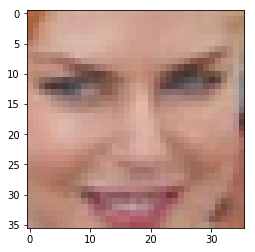

In [4]:
#print random image
print(data.shape)

a=np.random.randint(data.shape[0])

img=(data[a]+1.)/2. #scale to between 0 and 1 for display
plt.imshow(img,cmap='gray',interpolation=None)


# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [5]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.333)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

import keras
from keras.models import Sequential
from keras import layers as L
from keras.layers import LeakyReLU
from keras import backend as K
K.set_learning_phase(0)

Using TensorFlow backend.


In [6]:

CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8,kernel_initializer='he_normal'))
generator.add(LeakyReLU(alpha=0.2))

generator.add(L.Reshape((8,8,10)))
print(generator.output_shape)
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),kernel_initializer='he_normal'))
generator.add(LeakyReLU(alpha=0.2))
print(generator.output_shape)
generator.add(L.Dropout(0.2))

generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),kernel_initializer='he_normal'))
print(generator.output_shape)
generator.add(LeakyReLU(alpha=0.2))
generator.add(L.Dropout(0.1))

generator.add(L.Conv2DTranspose(128,kernel_size=(5,5),kernel_initializer='he_normal',padding='same'))
print(generator.output_shape)
generator.add(LeakyReLU(alpha=0.2))
generator.add(L.Dropout(0.1))

generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),strides=2,padding='same',kernel_initializer='he_normal'))
print(generator.output_shape)
generator.add(LeakyReLU(alpha=0.2))


generator.add(L.Conv2DTranspose(32,kernel_size=3,kernel_initializer='he_normal'))
print(generator.output_shape)
generator.add(L.Dropout(0.1))
generator.add(LeakyReLU(alpha=0.2))

generator.add(L.Conv2DTranspose(32,kernel_size=3,kernel_initializer='he_normal'))
print(generator.output_shape)
generator.add(LeakyReLU(alpha=0.1))

generator.add(L.Conv2DTranspose(32,kernel_size=3,kernel_initializer='he_normal'))
generator.add(LeakyReLU(alpha=0.1))
print(generator.output_shape)
#generator.add(L.Dropout(0.3))                                                                                                                                                                        \      


generator.add(L.Conv2D(3,kernel_size=3,activation='tanh',kernel_initializer='glorot_uniform'))
print(generator.output_shape)

generator.summary()





(None, 8, 8, 10)
(None, 12, 12, 64)
(None, 16, 16, 64)
(None, 16, 16, 128)
(None, 32, 32, 64)
(None, 34, 34, 32)
(None, 36, 36, 32)
(None, 38, 38, 32)
(None, 36, 36, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (InputLayer)           (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 640)               164480    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 640)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 10)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 12, 12, 64)        16064     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12,

In [7]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [8]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

discriminator.add(L.Conv2D(32,(3,3),strides=2,padding='same',kernel_initializer='he_uniform'))
discriminator.add(LeakyReLU(alpha=0.1))
print(discriminator.output_shape)
discriminator.add(L.Conv2D(32,(3,3),strides=2,padding='same',kernel_initializer='he_uniform'))
discriminator.add(LeakyReLU(alpha=0.1))
discriminator.add(L.Conv2D(64,(3,3),strides=2,padding='same',kernel_initializer='he_uniform'))
discriminator.add(LeakyReLU(alpha=0.1))
print(discriminator.output_shape)
discriminator.add(L.AveragePooling2D((2,2),padding='same'))
print(discriminator.output_shape)
discriminator.add(L.Conv2D(128,(3,3),padding='same',kernel_initializer='he_uniform'))
discriminator.add(LeakyReLU(alpha=0.1))
print(discriminator.output_shape)
discriminator.add(L.Conv2D(128,(3,3),padding='same',kernel_initializer='he_uniform'))
discriminator.add(LeakyReLU(alpha=0.1))
print(discriminator.output_shape)
discriminator.add(L.Flatten())
print(discriminator.output_shape)
discriminator.add(L.Dense(256,activation='tanh',kernel_initializer='glorot_uniform'))
print(discriminator.output_shape)
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))
discriminator.summary()




(None, 18, 18, 32)
(None, 5, 5, 64)
(None, 3, 3, 64)
(None, 3, 3, 128)
(None, 3, 3, 128)
(None, 1152)
(None, 256)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 36, 36, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 32)        896       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 64)          18496     
____________________________

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

![img](https://s24.postimg.org/cw4nognxx/gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [16]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

logp_real = discriminator(real_data)
print(logp_real.shape)

generated_data = generator(noise)

logp_gen = discriminator(generated_data)
print(logp_gen.shape)

(?, 2)
(?, 2)


In [17]:
########################
#discriminator training#
########################
surity1=np.random.uniform(0.8,1.15) #label smoothing
surity2=np.random.uniform(-1.0,0.2)
d_loss = -tf.reduce_mean(surity1*logp_real[:,1] + (1-surity2)*logp_gen[:,0])

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#tf.summary.scalar('disc_loss', d_loss)

#optimize
disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

In [18]:
########################
###generator training###
########################

g_loss = -tf.reduce_mean((logp_gen[:,1]))

#tf.summary.scalar('gen_loss', g_loss)
gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)

    

In [19]:
#merged = tf.summary.merge_all()
#train_writer = tf.summary.FileWriter('./logs',s.graph)

s.run(tf.global_variables_initializer())

### Auxiliary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [11]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    #print(images[np.where(images<-1 or  images>1)])
    #print(np.max(images[0]),np.min(images[0]),images[0])
    images=(images+1.)/2.
    #print(np.max(images[0]),np.min(images[0]),images[0])
    
    if np.var(images)!=0:
        images = images.clip(0.,1.)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1],bins=80)
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1],bins=80)
    plt.legend(loc='best')
    plt.show()

In [ ]:
#hid_layers=[]
#for layer_idx in range(len(generator.layers)):
#    if isinstance(generator.layers[layer_idx], L.Conv2DTranspose) or isinstance(generator.layers[layer_idx], L.Dense):
#        hid_layers.append(K.function([generator.layers[0].input],[generator.layers[layer_idx].output]))    
#inp=np.random.normal(size=(1, 256)).astype('float32')

#for layer in hid_layers:
 #   print(layer([inp])[0])

In [ ]:
#for layer_idx in range(len(generator.layers)):
#    if isinstance(generator.layers[layer_idx], L.Conv2DTranspose) or isinstance(generator.layers[layer_idx], L.Dense):
#        print(generator.layers[layer_idx].get_weights())

### Training
Main loop.
We just train generator and discriminator in a loop and plot results once every N iterations.

In [22]:
for i in range(10):
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    disc_loss,_=s.run([d_loss,disc_optimizer],feed_dict)
    print("Epoch: ",i,"disc loss is: ",disc_loss)

Epoch:  0 disc loss is:  1.96421
Epoch:  1 disc loss is:  1.94528
Epoch:  2 disc loss is:  1.88982
Epoch:  3 disc loss is:  1.87644
Epoch:  4 disc loss is:  1.88641
Epoch:  5 disc loss is:  1.84897
Epoch:  6 disc loss is:  1.83024
Epoch:  7 disc loss is:  1.80888
Epoch:  8 disc loss is:  1.82135
Epoch:  9 disc loss is:  1.78698


In [23]:
gen_loss=0
best_loss=5

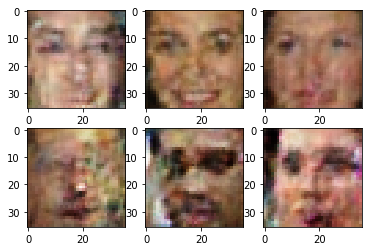

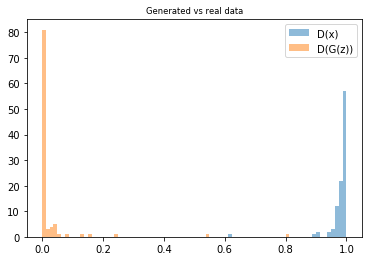

Epoch:  1 disc loss is:  0.32582 gen loss is:  6.15907
Epoch:  2 disc loss is:  0.181331 gen loss is:  7.00876
Epoch:  3 disc loss is:  0.349277 gen loss is:  6.79901
Epoch:  4 disc loss is:  0.14253 gen loss is:  6.76859
Epoch:  5 disc loss is:  0.121222 gen loss is:  6.70049
Epoch:  6 disc loss is:  0.183816 gen loss is:  5.89994
Epoch:  7 disc loss is:  0.156062 gen loss is:  7.1146
Epoch:  8 disc loss is:  0.261145 gen loss is:  6.5252
Epoch:  9 disc loss is:  0.273298 gen loss is:  6.35189
Epoch:  10 disc loss is:  0.170876 gen loss is:  7.06069
Epoch:  11 disc loss is:  0.360116 gen loss is:  6.00778
Epoch:  12 disc loss is:  0.272689 gen loss is:  6.13495
Epoch:  13 disc loss is:  0.146621 gen loss is:  6.59115
Epoch:  14 disc loss is:  0.418973 gen loss is:  5.67466
Epoch:  15 disc loss is:  0.209345 gen loss is:  7.22569
Epoch:  16 disc loss is:  0.289453 gen loss is:  6.01959
Epoch:  17 disc loss is:  0.264875 gen loss is:  5.92953
Epoch:  18 disc loss is:  0.328932 gen loss 

In [27]:
#test if training works
from IPython import display
#from tqdm import tnrange

for epoch in range(50):
    
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    if gen_loss<6:
        if disc_loss>1:
            for i in range(5):
                s.run(disc_optimizer,feed_dict)
        elif disc_loss>0.2:
            for i in range(4):
                s.run(disc_optimizer,feed_dict)
        else:
            for i in range(3):
                s.run(disc_optimizer,feed_dict)
    if gen_loss<2:
        disc_loss,gen_loss,_=s.run([d_loss,g_loss,gen_optimizer],feed_dict)
    else:
        s.run(gen_optimizer,feed_dict)
        disc_loss,gen_loss,_=s.run([d_loss,g_loss,gen_optimizer],feed_dict)
    print("Epoch: ",epoch,"disc loss is: ",disc_loss,"gen loss is: ",gen_loss)
    
    if epoch %50==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(100)
        if epoch>49 and ((gen_loss<1.3*best_loss and gen_loss<4) or gen_loss<1.5):
            generator.save_weights("best_weights.h5")
            best_loss=gen_loss
        if gen_loss>4.9:
           # generator.load_weights("best_weights.h5")
            pass

In [30]:
generator.load_weights('generator_weights2_100000.h5') #train on cloud gpus, load trained weights here
discriminator.load_weights('discriminator_weights2_100000.h5')

In [44]:
hid_layers=[]
for layer_idx in range(len(generator.layers)):
    if isinstance(generator.layers[layer_idx], L.Conv2DTranspose) or isinstance(generator.layers[layer_idx], L.Dense):
        hid_layers.append(K.function([generator.layers[0].input],[generator.layers[layer_idx].output]))    
inp=np.random.normal(size=(1, 256)).astype('float32')

for layer in hid_layers:
    print(layer([inp])[0][0][0])
    break

-0.902997


In [43]:
for layer_idx in range(len(generator.layers)):
    if isinstance(generator.layers[layer_idx], L.Conv2DTranspose) or isinstance(generator.layers[layer_idx], L.Dense):
        print(generator.layers[layer_idx].name,generator.layers[layer_idx].get_weights()[0])
        break

dense_12 [[-0.00024127 -0.01193478 -0.03454623 ..., -0.08190431  0.01176584
   0.05836243]
 [ 0.09169575  0.00534081 -0.13522357 ...,  0.13383108 -0.04534633
   0.05871198]
 [ 0.06829716 -0.04748307  0.07591756 ..., -0.18306942  0.01892022
  -0.07078008]
 ..., 
 [-0.01921949 -0.03584464  0.04456199 ...,  0.05260431  0.02702826
  -0.0046567 ]
 [ 0.01403716  0.1632119   0.06682524 ..., -0.01345954 -0.11276691
   0.04795024]
 [ 0.09424677 -0.01309661  0.00273853 ...,  0.17757671  0.02615486
  -0.06038361]]


In [49]:
from submit_honor import submit_honor
submit_honor((generator, discriminator),'ndev@nd.edu','jfkafvXmaEaAa4ez')

Submitted to Coursera platform. See results on assignment page!


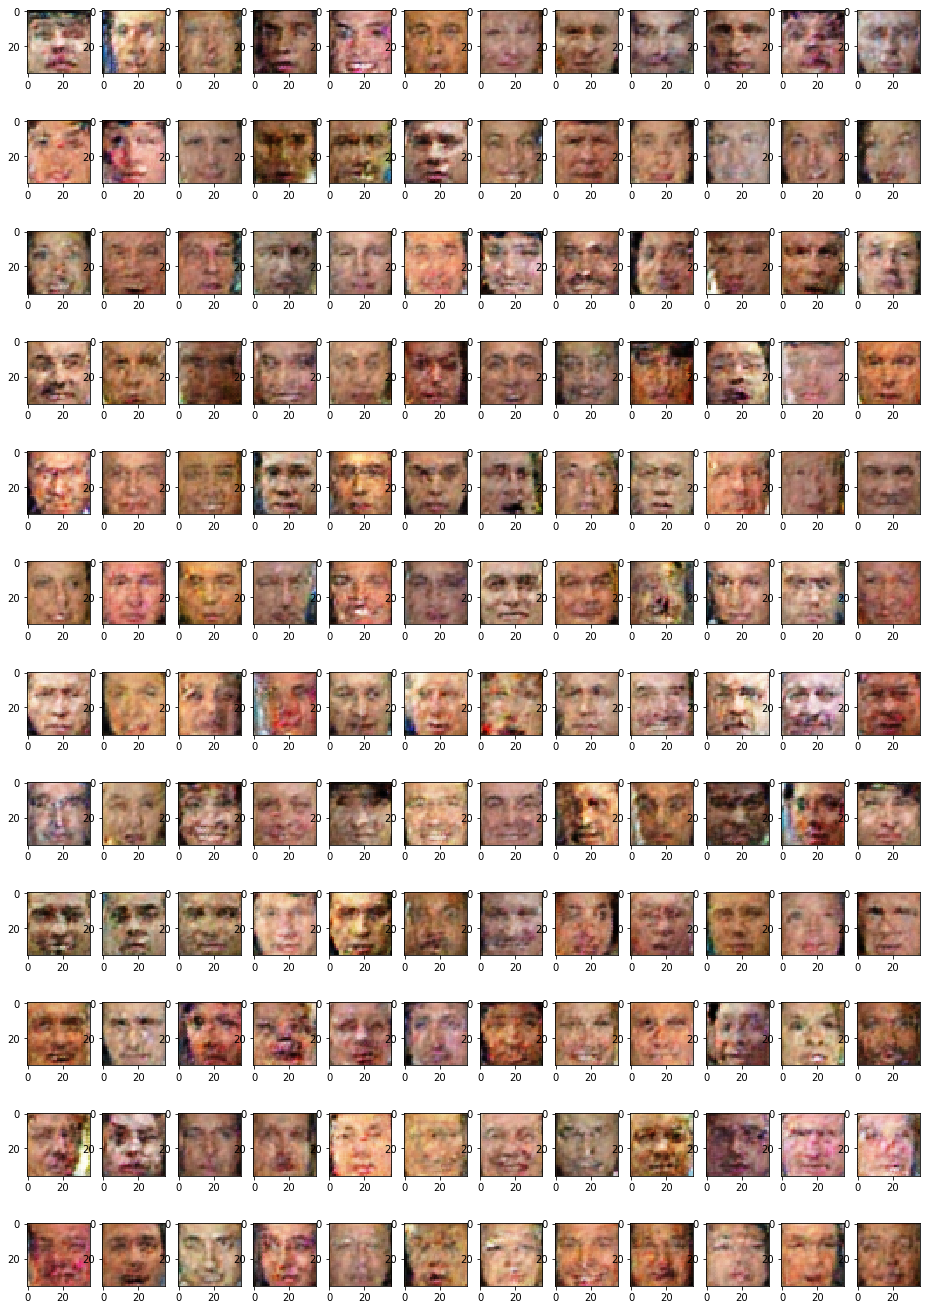

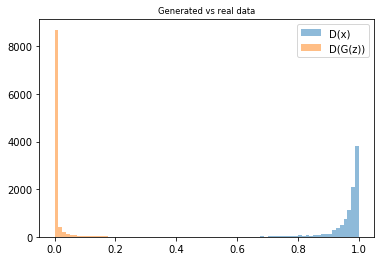

In [33]:
#The network was trained for about 100k iterations. 

plt.figure(figsize=[16,24])
sample_images(12,12)
sample_probas(10000)